# ARIMA

In [126]:
from cryptocmd import CmcScraper                     # Para descargar datos históricos de criptomonedas
import pandas as pd                                  # Para manejar los dataframes
from statsmodels.tsa.stattools import adfuller       # Test de estacionaridad
from statsmodels.tsa.arima.model import ARIMA        # Modelo que vamos a usar
from statsmodels.graphics.tsaplots import plot_acf   # Gráfico de autocorrelación
from statsmodels.graphics.tsaplots import plot_pacf  # Gráfico de autocorrelación parcial
import matplotlib.pyplot as plt                      # Gráficos
plt.style.use('ggplot')
from itertools import product                        # Producto cartesiano
from sklearn.metrics import mean_squared_error
import random

In [17]:
# Descarga de datos
df = CmcScraper('BTC', '28-04-2013', '01-01-2022').get_dataframe()

# Preparación de datos
df['Date'] = pd.to_datetime(df['Date'], format='%Y-%m-%d %H:%M:%S')
df.sort_values(by='Date', ascending=True, inplace=True)
df = df.loc[:, ['Date', 'Open', 'Close', 'High', 'Low']]
df = df.rename({'Date' : 'date', 'Open': 'open', 'Close': 'close', 'High': 'high', 'Low': 'low'}, axis=1)
df = df.set_index('date')
df = df.asfreq('D')
df = df.sort_index()

pd.set_option('display.max_columns', None)
display(df)
pd.reset_option('display.max_columns')

,open,close,high,low
date,,,,
2013-04-28,135.300003,134.210007,135.979996,132.100006
2013-04-29,134.444000,144.539993,147.488007,134.000000
2013-04-30,144.000000,139.000000,146.929993,134.050003
2013-05-01,139.000000,116.989998,139.889999,107.720001
2013-05-02,116.379997,105.209999,125.599998,92.281898
...,...,...,...,...
2021-12-28,50679.859377,47588.854777,50679.859377,47414.209925
2021-12-29,47623.870463,46444.710491,48119.740950,46201.494371
2021-12-30,46490.606049,47178.125843,47879.965500,46060.313166


Text(0, 0.5, 'Precio (USD)')

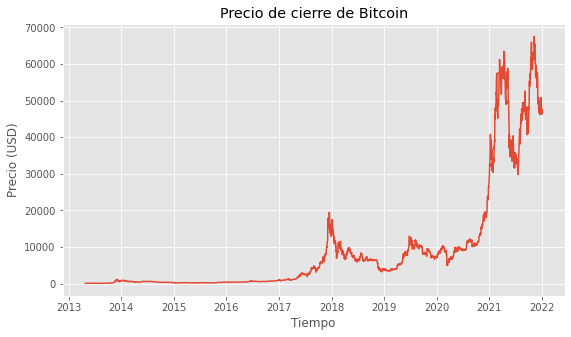

In [94]:
plt.figure(figsize=(9, 5))
plt.plot(df['close'])
plt.title("Precio de cierre de Bitcoin")
plt.xlabel("Tiempo")
plt.ylabel("Precio (USD)")

Para decidir si en este caso es apropiado construir un modelo ARMA o un modelo ARIMA, debemos decidir si esta serie de tiempo es estacionaria o no. A simple vista puede decirse que no lo es.
Hacemos un test aumentado de Dickey-Fuller (ADF):

In [39]:
# Prueba de Dickey-Fuller aumentada
result = adfuller(df["close"])
print(F"Valor del estadístico de ADF: {result[0]}")
print(F"Valor p: {result[1]}")
print("Valores críticos:")
for k,v in result[4].items():
    print(F"\t {k}: {v}")

Valor del estadístico de ADF: -0.5918943879018196
Valor p: 0.8728030643318618
Valores críticos:
	 1%: -3.4324336205696255
	 5%: -2.862460615102446
	 10%: -2.567260065043355


Dado que el valor p no es menor a 0.05, no se puede rechazar la hipótesis nula de la prueba de Dickey-Fuller, y por lo tanto concluimos que la serie temporal es no estacionaria.
Esto significa que debemos usar un modelo ARIMA, con parámetros `p`, `q` y `d`.

El valor de `d`, correspondiente al orden de la diferenciación que se aplica a la serie, puede determinarse experimentalmente realizando la diferenciación de la serie temporal hasta convertirla en estacionaria:

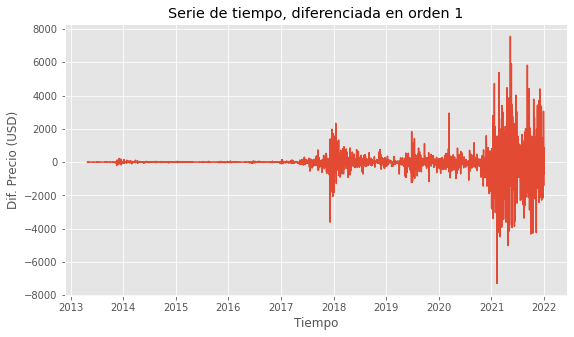

In [95]:
# Diferenciación
df_close = df['close']
df_diff = df_close.shift() - df_close
df_diff.dropna(inplace = True)

# Gráfico
plt.figure(figsize=(9, 5))
plt.plot(df_diff)
plt.title("Serie de tiempo, diferenciada en orden 1")
plt.xlabel("Tiempo")
plt.ylabel("Dif. Precio (USD)")
plt.show()

In [48]:
# Prueba de Dickey-Fuller aumentada
result = adfuller(df_diff)
print(F"Valor del estadístico de ADF: {result[0]}")
print(F"Valor p: {result[1]}")
print("Valores críticos:")
for k,v in result[4].items():
    print(F"\t {k}: {v}")

Valor del estadístico de ADF: -9.22099695847082
Valor p: 1.7801536101778882e-15
Valores críticos:
	 1%: -3.4324336205696255
	 5%: -2.862460615102446
	 10%: -2.567260065043355


Esta el valor de p es mucho menor a 0.05 (está en el orden de 10^(-15)) y por lo tanto sí podemos rechazar la hipótesis nula del test con certeza y concluir que la serie temporal es estacionaria. Por lo tanto, una diferenciación simple (`d` = 1) es suficiente para convertir la serie en estacionaria. 

Los valores de `p` y `q` se determinan mediante los gráficos de autocorrelación y autocorrelación parcial:

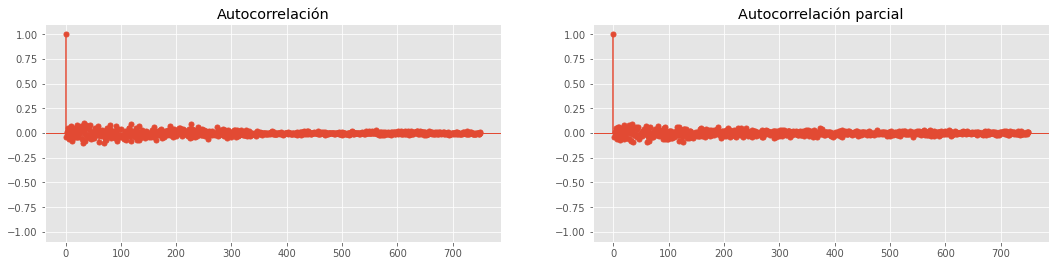

In [86]:
# Gráficos de autocorrelación y autocorrelación parcial
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(18, 4))
plot_acf(df_diff, ax=axes[0], linewidth = 1, lags=750, title = "Autocorrelación")
axes[0].set_ylim(-1.1, 1.1)
plot_pacf(df_diff, ax=axes[1], lags=750, method='ywm',  linewidth = 1, title = "Autocorrelación parcial")
axes[1].set_ylim(-1.1, 1.1)
plt.show();

Notar que tanto la autocorrelación como la autocorrelación parcial decaen drásticamente tras el primer desfasaje. Esto nos da la pauta de que sólo los valores muy recientes son buenos parámetros para pronosticar los valores futuros de la criptomoneda. Esto puede constatarse haciendo un gráfico de autocorrelación de la serie temporal a distintos intervalos:

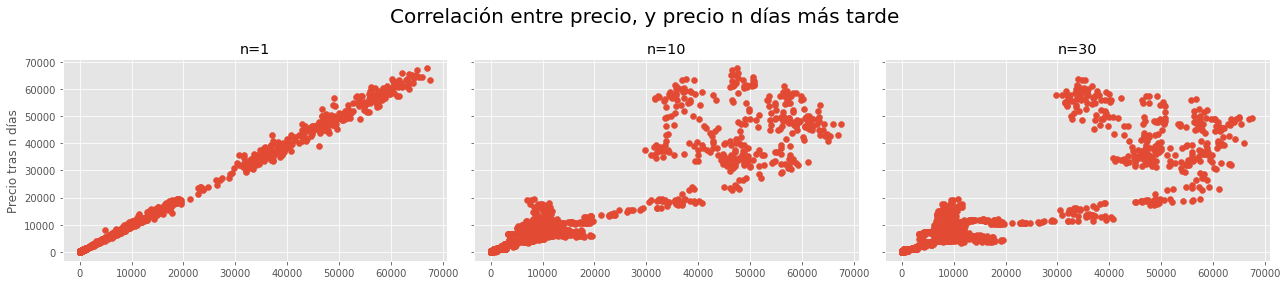

In [82]:
# Gráficos de autocorrelación a diferentes intervalos
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(18, 4), sharey='row')
fig.suptitle("Correlación entre precio, y precio n días más tarde", fontsize=20)
axes[0].scatter(df_close, df_close.shift())
axes[0].set_title('n=1')
axes[0].set_ylabel('Precio tras n días')

axes[1].scatter(df_close, df_close.shift(10))
axes[1].set_title('n=10')

axes[2].scatter(df_close, df_close.shift(30))
axes[2].set_title('n=30')

plt.tight_layout()
plt.show();

Como se puede observar, la correlación es bastante significativa entre los precios de días consecutivos. Sin embargo, el precio en un día no nos dice mucho acerca de cómo será el precio dentro de 10 días.

Entonces podemos asignar valores bajos tanto a `p` como a `q`, menores a 5.
Consideramos las configuraciones (`p`, 1, `q`) con `p` entre 0 y 5, y `q` entre 0 y 5. Evaluamos cada modelo en función del criterio de información de Akaike y el criterio de información bayesiano.

In [ ]:
p = 5
q = 5
aics = []
bics = []
for i in range(p+1):
    aics.append([])
    bics.append([])
    for j in range(q+1):
        model = ARIMA(df["close"], order=(i,1,j))
        fit = model.fit()
        aics[i].append(fit.aic)
        bics[i].append(fit.bic)

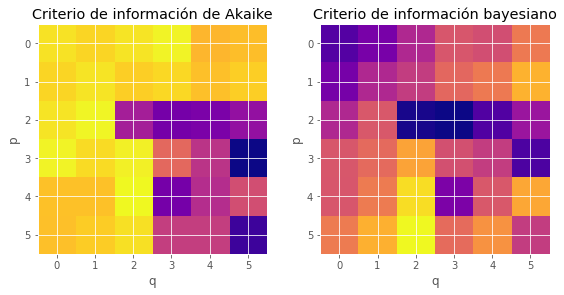

In [110]:
# Gráficos de AIC y BIC para cada configuración del modelo
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(8, 4))
axes[0].imshow(aics, cmap = 'plasma')
axes[0].set_title('Criterio de información de Akaike')
axes[0].set_xlabel('q')
axes[0].set_ylabel('p')

axes[1].imshow(bics, cmap = 'plasma')
axes[1].set_title('Criterio de información bayesiano')
axes[1].set_xlabel('q')
axes[1].set_ylabel('p')

plt.tight_layout()
plt.show();

La configuración con `p`=3 y `q`=5 es la que tiene los menores valores para ambos criterios, y por lo tanto es la óptima.

In [ ]:
model = ARIMA(df["close"], order=(3,1,5))
model_fit = model.fit()
train_percentage = 0.75
X = df["close"].values
train_size = int(len(X) * train_percentage)
predictions = model_fit.predict(train_size,len(X)-1)
test = X[train_size:len(X)]
error = mean_squared_error(test, predictions)

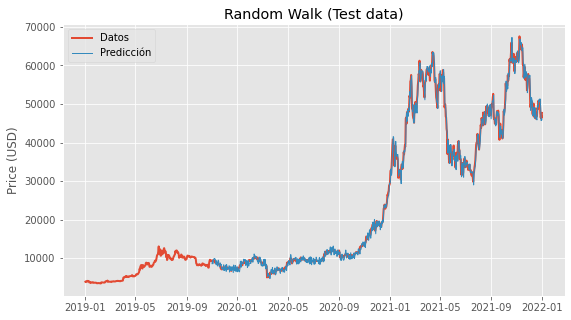

In [137]:
# Gráfico del resultado de la predicción
plt.figure(figsize=(9, 5))
plt.plot(df['2019-01-01':]["close"], linewidth=2, label='Datos')
plt.plot(predictions['2019-01-01':], linewidth=1, label='Predicción')
plt.title('Random Walk (Test data)')
plt.ylabel('Price (USD)')
plt.legend()
plt.show()

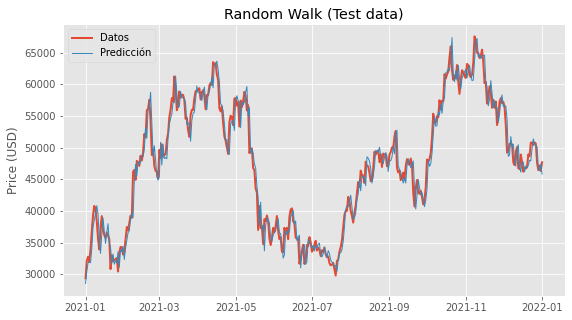

In [141]:
# Gráfico del resultado de la predicción
plt.figure(figsize=(9, 5))
plt.plot(df['2021-01-01':]["close"], linewidth=2, label='Datos')
plt.plot(predictions['2021-01-01':], linewidth=1, label='Predicción')
plt.title('Random Walk (Test data)')
plt.ylabel('Price (USD)')
plt.legend()
plt.show()